In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
#import numpy as np
import matplotlib.pyplot as plt

In [44]:
print(torch.cuda.is_available())
# Configure device
device = torch.device('cuda')

True


In [45]:
# Data Augmentmention experiments
train_transform1 = transforms.Compose([transforms.ToTensor()])
train_transform2 = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(32)])
train_transform3 = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip()])
train_transform4 = transforms.Compose([transforms.ToTensor()
                                      ,transforms.RandomCrop(32)
                                      ,transforms.RandomHorizontalFlip()
                                      ])

test_transform = transforms.ToTensor()

In [46]:
# Define the block architecture
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the ResNet-18 architecture
class ResNet18(nn.Module):
    def __init__(self, block, layers):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 classes

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out



Files already downloaded and verified
Epoch [1/50], Training Loss: 0.0121, Testing Loss: 0.0132, Training Acc: 0.5628, Testing Acc: 0.5725
Epoch [2/50], Training Loss: 0.0078, Testing Loss: 0.0111, Training Acc: 0.7267, Testing Acc: 0.6419
Epoch [3/50], Training Loss: 0.0060, Testing Loss: 0.0067, Training Acc: 0.7897, Testing Acc: 0.7662
Epoch [4/50], Training Loss: 0.0047, Testing Loss: 0.0084, Training Acc: 0.8349, Testing Acc: 0.7182
Epoch [5/50], Training Loss: 0.0036, Testing Loss: 0.0066, Training Acc: 0.8725, Testing Acc: 0.7850
Epoch [6/50], Training Loss: 0.0028, Testing Loss: 0.0069, Training Acc: 0.9039, Testing Acc: 0.7878
Epoch [7/50], Training Loss: 0.0020, Testing Loss: 0.0080, Training Acc: 0.9302, Testing Acc: 0.7723
Epoch [8/50], Training Loss: 0.0015, Testing Loss: 0.0071, Training Acc: 0.9486, Testing Acc: 0.8083
Epoch [9/50], Training Loss: 0.0011, Testing Loss: 0.0080, Training Acc: 0.9624, Testing Acc: 0.7983
Epoch [10/50], Training Loss: 0.0009, Testing Loss: 0

(0.0, 1.018667)

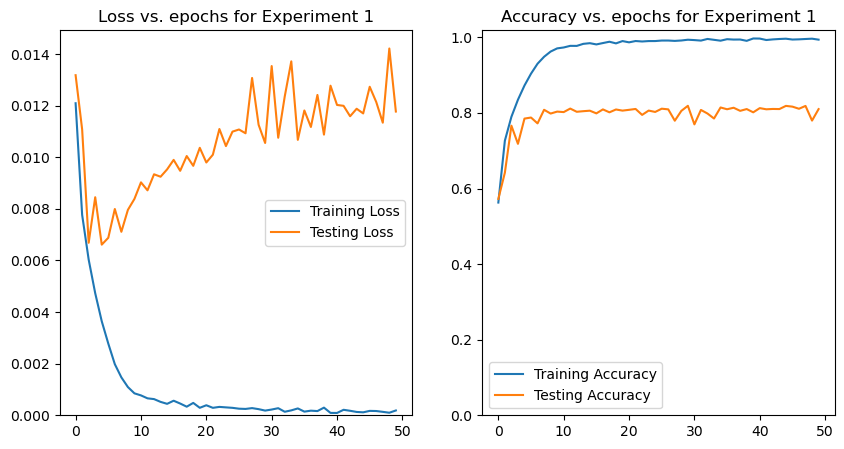

In [47]:

#Experiment 1

# Hyper-parameters
epochs = 50
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform1,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []

# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 1')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 1')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/50], Training Loss: 0.0122, Testing Loss: 0.0100, Training Acc: 0.5613, Testing Acc: 0.6476
Epoch [2/50], Training Loss: 0.0077, Testing Loss: 0.0079, Training Acc: 0.7301, Testing Acc: 0.7252
Epoch [3/50], Training Loss: 0.0059, Testing Loss: 0.0079, Training Acc: 0.7951, Testing Acc: 0.7367
Epoch [4/50], Training Loss: 0.0046, Testing Loss: 0.0074, Training Acc: 0.8374, Testing Acc: 0.7593
Epoch [5/50], Training Loss: 0.0035, Testing Loss: 0.0079, Training Acc: 0.8762, Testing Acc: 0.7405
Epoch [6/50], Training Loss: 0.0027, Testing Loss: 0.0078, Training Acc: 0.9059, Testing Acc: 0.7703
Epoch [7/50], Training Loss: 0.0019, Testing Loss: 0.0073, Training Acc: 0.9336, Testing Acc: 0.7900
Epoch [8/50], Training Loss: 0.0014, Testing Loss: 0.0069, Training Acc: 0.9512, Testing Acc: 0.8109
Epoch [9/50], Training Loss: 0.0011, Testing Loss: 0.0083, Training Acc: 0.9628, Testing Acc: 0.7945
Epoch [10/50], Training Loss: 0.0009, Testing Loss: 0

(0.0, 1.01935)

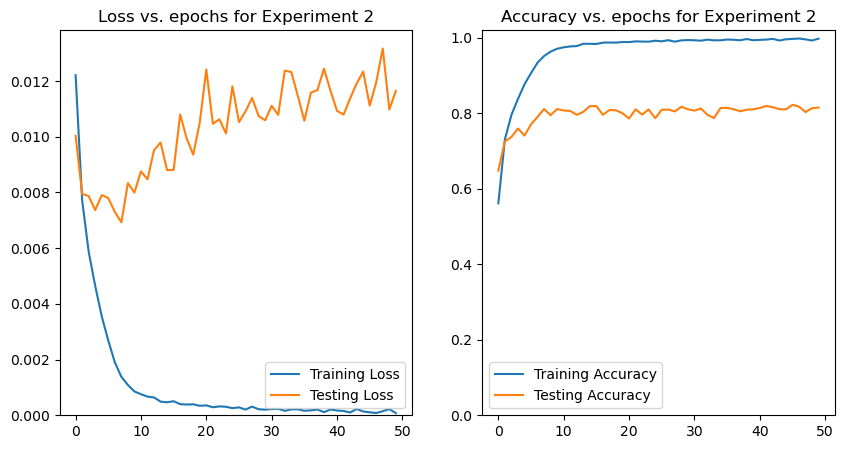

In [54]:

#Experiment 2

# Hyper-parameters
epochs = 50
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform2,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 2')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 2')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/50], Training Loss: 0.0122, Testing Loss: 0.0110, Training Acc: 0.5586, Testing Acc: 0.6222
Epoch [2/50], Training Loss: 0.0079, Testing Loss: 0.0081, Training Acc: 0.7233, Testing Acc: 0.7187
Epoch [3/50], Training Loss: 0.0063, Testing Loss: 0.0075, Training Acc: 0.7819, Testing Acc: 0.7424
Epoch [4/50], Training Loss: 0.0053, Testing Loss: 0.0074, Training Acc: 0.8166, Testing Acc: 0.7469
Epoch [5/50], Training Loss: 0.0045, Testing Loss: 0.0068, Training Acc: 0.8449, Testing Acc: 0.7691
Epoch [6/50], Training Loss: 0.0039, Testing Loss: 0.0057, Training Acc: 0.8643, Testing Acc: 0.8097
Epoch [7/50], Training Loss: 0.0034, Testing Loss: 0.0055, Training Acc: 0.8857, Testing Acc: 0.8199
Epoch [8/50], Training Loss: 0.0029, Testing Loss: 0.0060, Training Acc: 0.9009, Testing Acc: 0.8132
Epoch [9/50], Training Loss: 0.0024, Testing Loss: 0.0050, Training Acc: 0.9167, Testing Acc: 0.8388
Epoch [10/50], Training Loss: 0.0021, Testing Loss: 0

(0.0, 1.014363)

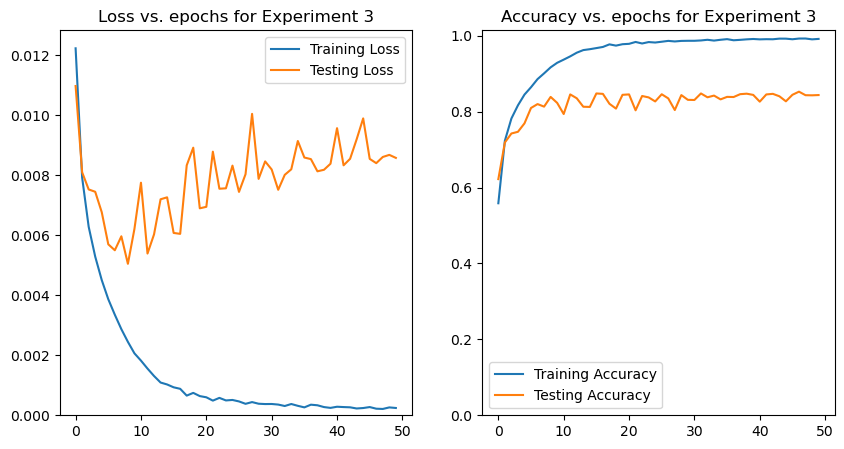

In [49]:

#Experiment 3

# Hyper-parameters
epochs = 50
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform3,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 3')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 3')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/50], Training Loss: 0.0122, Testing Loss: 0.0108, Training Acc: 0.5632, Testing Acc: 0.6204
Epoch [2/50], Training Loss: 0.0079, Testing Loss: 0.0079, Training Acc: 0.7228, Testing Acc: 0.7242
Epoch [3/50], Training Loss: 0.0063, Testing Loss: 0.0073, Training Acc: 0.7840, Testing Acc: 0.7406
Epoch [4/50], Training Loss: 0.0052, Testing Loss: 0.0070, Training Acc: 0.8190, Testing Acc: 0.7674
Epoch [5/50], Training Loss: 0.0045, Testing Loss: 0.0079, Training Acc: 0.8454, Testing Acc: 0.7404
Epoch [6/50], Training Loss: 0.0039, Testing Loss: 0.0060, Training Acc: 0.8672, Testing Acc: 0.7997
Epoch [7/50], Training Loss: 0.0034, Testing Loss: 0.0050, Training Acc: 0.8821, Testing Acc: 0.8332
Epoch [8/50], Training Loss: 0.0029, Testing Loss: 0.0054, Training Acc: 0.9018, Testing Acc: 0.8251
Epoch [9/50], Training Loss: 0.0025, Testing Loss: 0.0057, Training Acc: 0.9146, Testing Acc: 0.8179
Epoch [10/50], Training Loss: 0.0021, Testing Loss: 0

(0.0, 1.014092)

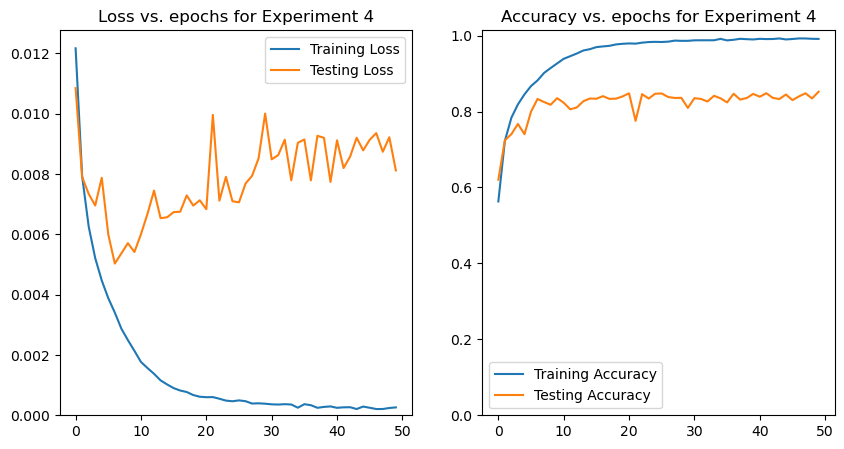

In [50]:

#Experiment 4

# Hyper-parameters
epochs = 50
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform4,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 4')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 4')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/50], Training Loss: 0.0123, Testing Loss: 0.0105, Training Acc: 0.5557, Testing Acc: 0.6329
Epoch [2/50], Training Loss: 0.0082, Testing Loss: 0.0080, Training Acc: 0.7143, Testing Acc: 0.7234
Epoch [3/50], Training Loss: 0.0065, Testing Loss: 0.0067, Training Acc: 0.7742, Testing Acc: 0.7712
Epoch [4/50], Training Loss: 0.0054, Testing Loss: 0.0071, Training Acc: 0.8115, Testing Acc: 0.7600
Epoch [5/50], Training Loss: 0.0047, Testing Loss: 0.0057, Training Acc: 0.8365, Testing Acc: 0.8082
Epoch [6/50], Training Loss: 0.0040, Testing Loss: 0.0054, Training Acc: 0.8602, Testing Acc: 0.8228
Epoch [7/50], Training Loss: 0.0035, Testing Loss: 0.0056, Training Acc: 0.8784, Testing Acc: 0.8123
Epoch [8/50], Training Loss: 0.0030, Testing Loss: 0.0059, Training Acc: 0.8959, Testing Acc: 0.8186
Epoch [9/50], Training Loss: 0.0026, Testing Loss: 0.0058, Training Acc: 0.9094, Testing Acc: 0.8223
Epoch [10/50], Training Loss: 0.0022, Testing Loss: 0

(0.0, 1.010457)

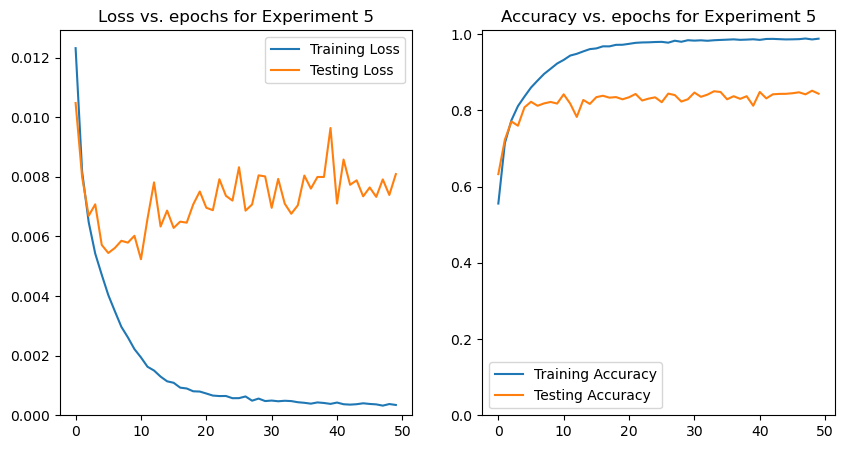

In [51]:

#Experiment 5

# Hyper-parameters
epochs = 50
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 01e-5

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform4,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 5')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 5')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


plt.plot(epochs_axis, losses5, Label="Training Loss")
plt.plot(epochs_axis, losses5_test, Label="Testing Loss")
plt.legend

Files already downloaded and verified
Epoch [1/50], Training Loss: 0.0122, Testing Loss: 0.0100, Training Acc: 0.5637, Testing Acc: 0.6535
Epoch [2/50], Training Loss: 0.0079, Testing Loss: 0.0100, Training Acc: 0.7230, Testing Acc: 0.6673
Epoch [3/50], Training Loss: 0.0062, Testing Loss: 0.0095, Training Acc: 0.7859, Testing Acc: 0.6914
Epoch [4/50], Training Loss: 0.0048, Testing Loss: 0.0072, Training Acc: 0.8340, Testing Acc: 0.7650
Epoch [5/50], Training Loss: 0.0038, Testing Loss: 0.0080, Training Acc: 0.8660, Testing Acc: 0.7526
Epoch [6/50], Training Loss: 0.0029, Testing Loss: 0.0081, Training Acc: 0.8983, Testing Acc: 0.7595
Epoch [7/50], Training Loss: 0.0021, Testing Loss: 0.0066, Training Acc: 0.9258, Testing Acc: 0.8061
Epoch [8/50], Training Loss: 0.0015, Testing Loss: 0.0075, Training Acc: 0.9464, Testing Acc: 0.7887
Epoch [9/50], Training Loss: 0.0011, Testing Loss: 0.0087, Training Acc: 0.9597, Testing Acc: 0.7776
Epoch [10/50], Training Loss: 0.0010, Testing Loss: 0

(0.0, 1.0150970000000001)

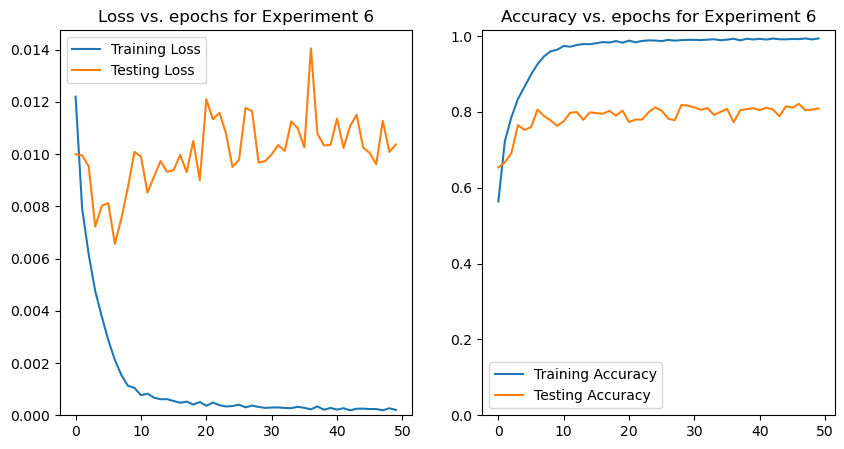

In [52]:

#Experiment 6

# Hyper-parameters
epochs = 50
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 1e-5

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform2,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 6')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 6')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()
